#### Hartree-Fock in Pytorch

In [1]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear
from scipy.sparse import lil_matrix
import torch
import torch.nn as nn
import torch.optim as optim

file_name='data/usdb.nat'


SPS=SingleParticleState(file_name=file_name)

In [2]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:54<00:00,  2.29s/it]


In [3]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$Ne'

In [4]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-41.39649007]
total_m= [-3.45589442e-19]
dimension= 640


Hartree-Fock method

In [5]:
#model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=12)


In [ ]:

optimizer = optim.Adam(model.parameters(), lr=0.1)

num_steps = 600
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

tensor(5.9001, dtype=torch.float64, grad_fn=<SumBackward0>)
Step    0 | Energy = -17.246844
tensor(5.9038, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9070, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9096, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9117, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9132, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9142, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9147, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9147, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9142, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9132, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9118, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9100, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9078, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9052, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.9024, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5

In [7]:
print(torch.sum(torch.abs(model.C_p)))

tensor(5.6293, dtype=torch.float64, grad_fn=<SumBackward0>)


In [8]:
def slater_determinants_combined(C_n, C_p, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]
    N_p = C_p.shape[1]

    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()
        occ_p = torch.nonzero(occ[M_half:]).squeeze()+M_half

        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]
        Cp_sub = C_p[occ_p, :]  # shape [N_p, N_p]

        if Cn_sub.shape[0] != N_n or Cp_sub.shape[0] != N_p:
            # Skip invalid configurations (e.g., wrong number of particles)
            continue

        det_n = torch.det(Cn_sub)
        det_p = torch.det(Cp_sub)
        psi[i] = det_n * det_p

    return psi  # [F]


In [9]:

psi_hf=slater_determinants_combined(model.C_n, model.C_p, torch.tensor(NSMHamiltonian.basis))

psi_hf=psi_hf.detach().numpy()

psi_hf=psi_hf/np.linalg.norm(psi_hf)



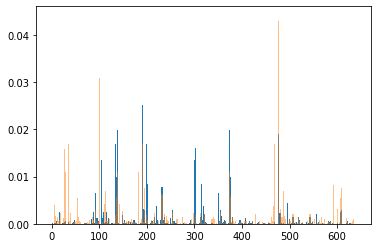

-39.027838108568886
fidelity= 0.4079846645059947


In [10]:
plt.bar(np.arange(psi_hf.shape[0]),psi_hf.conjugate()*psi_hf)
plt.bar(np.arange(psi_hf.shape[0])+0.1,psi0[:,0].conjugate()*psi0[:,0],alpha=0.5)
plt.show()

print(psi_hf.conjugate() @ NSMHamiltonian.hamiltonian @ psi_hf)


print('fidelity=',psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)))

In [13]:
def check_orthonormal(C, tol=1e-6):
    I = torch.eye(C.shape[1], dtype=C.dtype, device=C.device)
    test = C.T @ C
    return torch.allclose(test, I, atol=tol)

print(check_orthonormal(model.C_p))

True


#### Sample Based Diagonalization HF and exact Gs

In [14]:
n_instances=9000

In [15]:
prob_exact=np.conjugate(psi0[:,0])*psi0[:,0]
nbatch=50
ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],10)
errors_sdg_gs=[]
energies_sdg_gs=[]
fidelities_exact=[]

deviations_exact=[]
for n_instances in ns_instances:
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch): 
                selection=np.random.choice(np.arange(prob_exact.shape[0]),size=n_instances,replace=False,p=prob_exact)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

                psi_selected[selection]=effective_psi0[:,0]
                
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
                std_energy+=effective_egs**2
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities_exact.append(ensamble_fidelity)
        errors_sdg_gs.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_gs.append(ensamble_energy)
        deviations_exact.append(std_energy)
        print(ensamble_energy)


-23.41369453987073
-29.01525905591377
-30.329115442966376
-31.05943101257253
-31.556523004796478
-32.15629064388856
-32.887782535577315
-33.32713600579298
-33.84286038025484
-34.401310508212234
-34.86738920965607
-35.2273143995007
-35.63420043241765
-35.998387859798726
-36.35155836974988
-36.68631406859948
-37.0772160424276
-37.37365158692787
-37.60224581075122
-37.85761991477542
-38.12870486633988
-38.34015736617436
-38.562553116115055
-38.81206280656742
-38.96554819109264
-39.118710452286116
-39.34579521378307
-39.4873402737355
-39.669914921652996
-39.807228218451925
-39.9517860229596
-40.08307749072488
-40.21073246997554
-40.291935437121495
-40.403308802334614
-40.49273293725056
-40.5908592290111
-40.67136737672424
-40.75209994954695
-40.821528788246276
-40.892003856640905
-40.951449988020016
-40.996823952614044
-41.05111514959114
-41.10230422808889
-41.13909699897272
-41.18104802853052
-41.21685212118213
-41.2436253016037
-41.27022942075459
-41.29335141732333
-41.31342418292278
-41

In [16]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]
errors_sdg_hf=[]
energies_sdg_hf=[]
fidelities=[]

deviations=[]
for n_instances in ns_instances:
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch): 
                selection=np.random.choice(np.arange(prob_exact.shape[0]),size=n_instances,replace=False,p=prob_hf)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

                psi_selected[selection]=effective_psi0[:,0]
                
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
                std_energy+=effective_egs**2
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities.append(ensamble_fidelity)
        errors_sdg_hf.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_hf.append(ensamble_energy)
        deviations.append(std_energy)
        print(ensamble_energy)


-23.501969251253396
-29.845141099018207
-30.89622602474104
-31.70126652242898
-32.42096788647891
-33.023480550548086
-33.79452346545591
-34.20929083143682
-34.62860165345507
-35.124342640773506
-35.514426728916895
-35.833070416712125
-36.1918624664683
-36.5927206256081
-36.840958753029405
-37.15948561275125
-37.36621257802643
-37.61936372123371
-37.80152784435884
-37.9688351271839
-38.11905399407134
-38.26553054355825
-38.374317274287165
-38.49020335069829
-38.59830887374385
-38.70266065150086
-38.79782305960842
-38.88371138778329
-38.96158573644452
-39.03375102458621
-39.086361287951675
-39.14582235044555
-39.1930786703675
-39.23950783929598
-39.29003071599635
-39.328458635707
-39.36551368851438
-39.40692687181233
-39.44675453005187
-39.49209200568555
-39.53745627677219
-39.586704026229235
-39.6430942399642
-39.6903010702465
-39.740220920315465
-39.7897856918457
-39.82298770335091
-39.857310594417775
-39.8925655292616
-39.93376934305051
-39.97830343343821
-40.029980975310124
-40.09893

Useless

In [ ]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf_clever=[]
energies_sdg_hf_clever=[]
fidelities_clever=[]
max_iterations=100
prob_sampler=prob_hf.copy()
ns_instances_clever=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],5)
selection=np.random.choice(np.arange(prob_hf.shape[0]),size=2,replace=False,p=prob_hf)
selected_samples=[selection[0],selection[1]]
effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

prob_sampler[selected_samples]=0
prob_sampler=prob_sampler/np.sum(prob_sampler)

effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
e_old=effective_egs.copy()

for r in range(NSMHamiltonian.hamiltonian.shape[0]-3): 
    
    low_energy=effective_egs.copy()
    for i in range(max_iterations):
        
        selection=np.random.choice(np.arange(prob_hf.shape[0]),size=5,replace=False,p=prob_sampler)
        tentative_selection=selected_samples+list(selection)
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[tentative_selection,:][:,tentative_selection]
        egs_tentative,psi0_tentative=eigsh(effective_hamiltonian,k=1,which='SA')

        if effective_egs <= low_energy:
            psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
            final_selection=tentative_selection
            low_energy=effective_egs
            effective_egs=egs_tentative.copy()
            psi_selected[tentative_selection]=psi0_tentative[:,0]
    print(effective_egs)
    selected_samples=final_selection
    prob_sampler[selected_samples]=0
    prob_sampler=prob_sampler/np.sum(prob_sampler)
    fidelities_clever.append(1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0])))
    errors_sdg_hf_clever.append(np.abs((effective_egs[0]-egs[0])/egs[0]))
    energies_sdg_hf_clever.append(effective_egs[0])

    
    

128 127


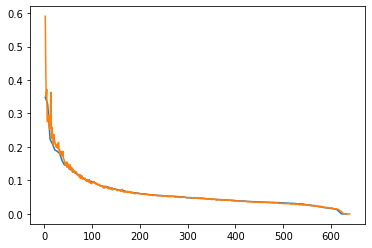

In [28]:
print(len(ns_instances_clever),len(errors_sdg_hf_clever))

plt.plot(ns_instances_clever[:-1],errors_sdg_hf_clever)
plt.plot(ns_instances,errors_sdg_hf)
plt.show()

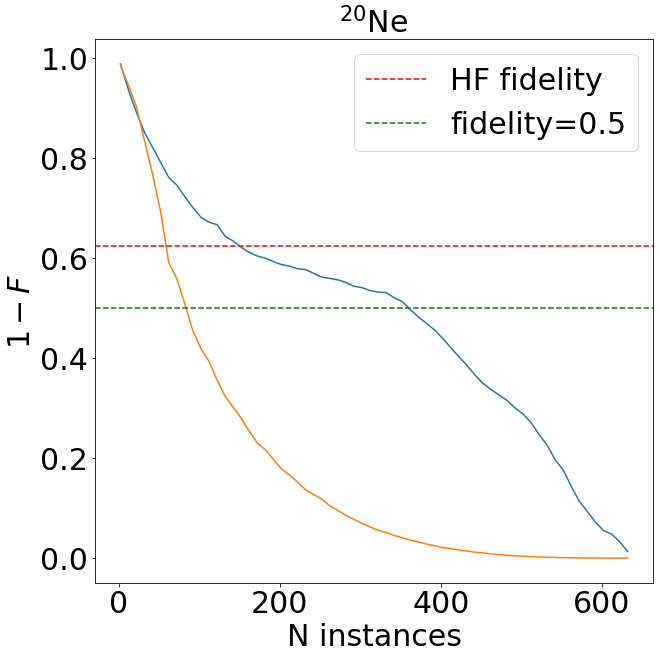

In [17]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,fidelities)
plt.plot(ns_instances,fidelities_exact)

plt.axhline(y=1-psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)),label='HF fidelity',color='red',linestyle='--')
plt.axhline(y=0.5,label='fidelity=0.5',color='green',linestyle='--')
plt.tick_params(labelsize=30)
plt.xlabel('N instances',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.title(title,fontsize=30)
plt.legend(fontsize=30)
plt.show()

In [18]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf_mixed=[]
energies_sdg_hf_mixed=[]
fidelities_mixed=[]
deviations_mixed=[]
nbatch=100


for n_instances in ns_instances: 
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch):
                selection=np.random.choice(np.arange(prob_hf.shape[0]),size=n_instances,replace=False,p=prob_hf)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
                

                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                std_energy+=effective_egs**2
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
        
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2
        
                
        prob_hf=0.95*prob_hf+0.05*ensamble_prob_selected
        prob_hf=prob_hf/np.sum(prob_hf)
        fidelities_mixed.append(ensamble_fidelity)
        errors_sdg_hf_mixed.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_hf_mixed.append(ensamble_energy)
        deviations_mixed.append(std_energy)
        print(effective_egs)

[-21.98003537]
[-30.32374606]
[-28.18730588]
[-32.35483564]
[-32.3339701]
[-32.99924386]
[-34.20002171]
[-34.09788228]
[-34.33809918]
[-35.36242043]
[-36.09514723]
[-36.00189835]
[-36.26448567]
[-36.69233461]
[-37.23948706]
[-37.56202023]
[-37.65768792]
[-37.7539825]
[-38.01517857]
[-38.10212041]
[-38.25091599]
[-38.43225969]
[-38.40066483]
[-38.66399079]
[-38.67374214]
[-38.84776193]
[-38.85972723]
[-38.93980661]
[-39.0789467]
[-39.12299397]
[-39.15843069]
[-39.21010612]
[-39.25486595]
[-39.29917305]
[-39.33117131]
[-39.34329554]
[-39.36680866]
[-39.40378968]
[-39.53396609]
[-39.63720907]
[-39.71090894]
[-39.75790711]
[-39.78611134]
[-39.80003907]
[-39.81333211]
[-39.82112554]
[-39.8261874]
[-39.82816742]
[-40.07670924]
[-40.15123152]
[-40.16113259]
[-40.1651497]
[-40.17360289]
[-40.53341662]
[-40.64989331]
[-40.69061064]
[-40.70670221]
[-40.71336073]
[-40.71937408]
[-40.72063506]
[-40.92149742]
[-41.24596087]
[-41.27536134]
[-41.27820751]


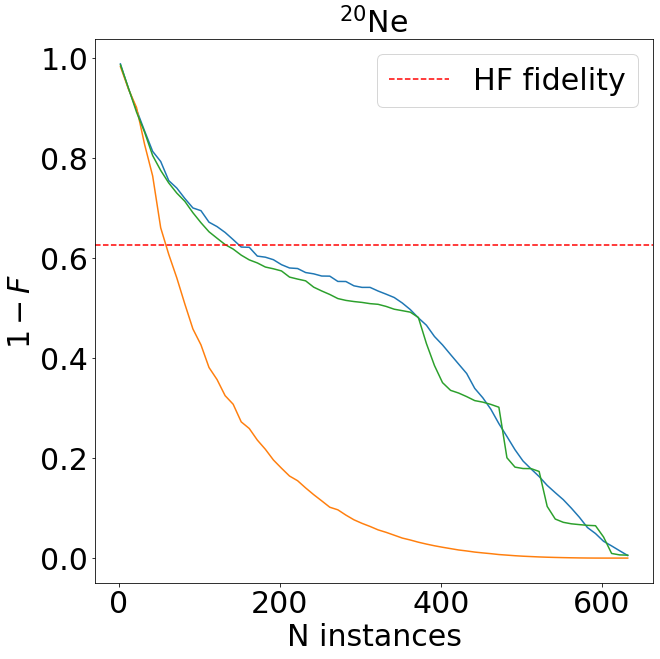

In [19]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,fidelities)
plt.plot(ns_instances,fidelities_exact)
plt.plot(ns_instances,fidelities_mixed)

plt.axhline(y=1-psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)),label='HF fidelity',color='red',linestyle='--')

plt.tick_params(labelsize=30)
plt.xlabel('N instances',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.title(title,fontsize=30)
plt.legend(fontsize=30)
plt.show()

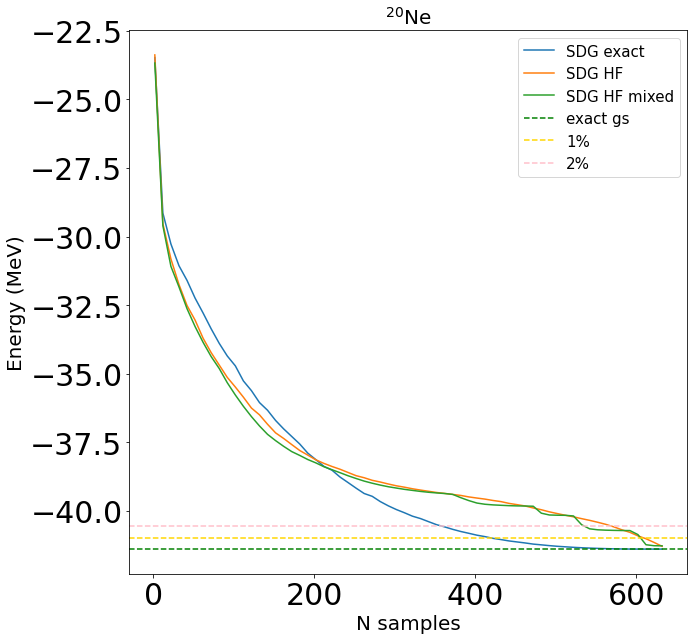

(64,)


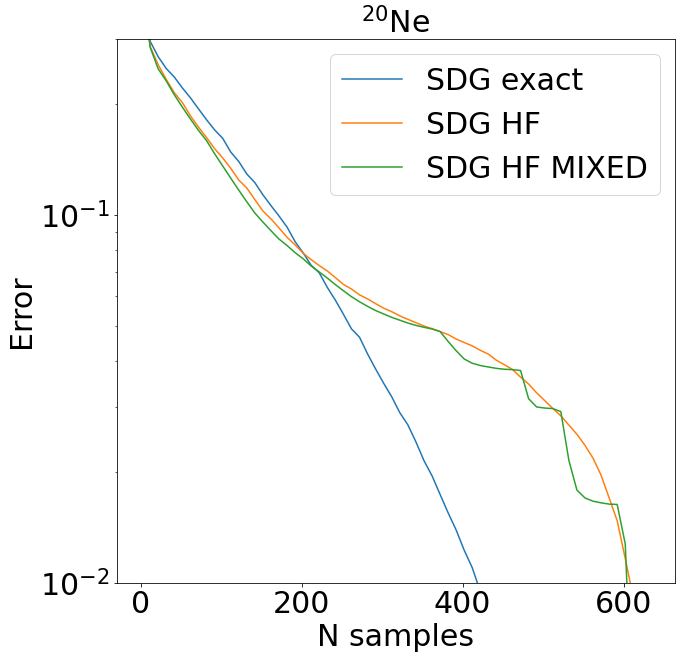

In [20]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,energies_sdg_gs,label='SDG exact')
plt.plot(ns_instances,energies_sdg_hf,label='SDG HF')
plt.plot(ns_instances,energies_sdg_hf_mixed,label='SDG HF mixed')
#plt.axhline(y=model().detach().numpy(),color='red',linestyle='--',label='HF')
plt.axhline(y=egs[0],color='green',linestyle='--',label='exact gs')
plt.axhline(y=egs[0]*(0.99),color='gold',linestyle='--',label='1%')
plt.axhline(y=egs[0]*(0.98),color='pink',linestyle='--',label='2%')
plt.xlabel('N samples',fontsize=20)
plt.ylabel('Energy (MeV)',fontsize=20)
plt.legend(fontsize=15)
plt.title(title,fontsize=20)
plt.tick_params(labelsize=30)
plt.show()

energies_sdg_hf=np.asarray(energies_sdg_hf)
energies_sdg_gs=np.asarray(energies_sdg_gs)
energies_sdg_hf_mixed=np.asarray(energies_sdg_hf_mixed)
print(energies_sdg_hf_mixed.shape)
plt.figure(figsize=(10,10))
plt.plot(ns_instances,np.abs((energies_sdg_gs-egs[0])/egs[0]),label='SDG exact')
plt.plot(ns_instances,np.abs((energies_sdg_hf-egs[0])/egs[0]),label='SDG HF')
plt.plot(ns_instances,np.abs((energies_sdg_hf_mixed-egs[0])/egs[0]),label='SDG HF MIXED')

plt.xlabel('N samples',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.tick_params(labelsize=30)
plt.ylim([10**-2,0.3])

plt.title(title,fontsize=30)
plt.semilogy()
plt.legend(fontsize=30)
plt.show()

#### Method using a Partial Adapt VQE

In [21]:
from src.hartree_fock_library import HartreeFock,HartreeFockVariational,gram_schmidt
from src.hamiltonian_utils import FermiHubbardHamiltonian
import numpy as np
from src.nuclear_physics_utils import SingleParticleState,get_twobody_nuclearshell_model
import torch
from typing import Dict,List
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
#from src.qml_models import AdaptVQEFermiHubbard
import matplotlib.pyplot as plt
from scipy import sparse
#from adapt_vqe_old import AdaptVQEFermiHubbard

In [43]:
def miquel_constrainer(idxs:List[int]):
    
    if SPS.projection_conservation(idxs=idxs):
        if NSMHamiltonian.charge_computation(initial_indices=idxs[:2],final_indices=idxs[2:]):
            op=NSMHamiltonian.adag_adag_a_a_matrix(idxs[0],idxs[1],idxs[2],idxs[3])
            diag_op = sparse.diags(op.diagonal())

            non_diag_op =np.abs( op - diag_op)
            if not(np.isclose(non_diag_op.sum(),0.)):
                condition=True
            else:
                condition=False
        
        else:
            condition=False
    else:
        condition=False
                
    return condition

def miquel_contrained_3(idx:List[int]):
    size=12    
    i1,i2,j1,j2=idx
    if (i1<size and i2>=size) or (i2<size and i1>=size):
        condition=True
    else:
        condition=False
        
    return condition
    


def miquel_constrainer_2(idxs:List[int]):
    _,_,j0,_,_,tz0=SPS.state_encoding[idxs[0]]
    _,_,j1,_,_,tz1=SPS.state_encoding[idxs[1]]
    _,_,j2,_,_,tz2=SPS.state_encoding[idxs[2]]
    _,_,j3,_,_,tz3=SPS.state_encoding[idxs[3]]
    
    j_tot_i = np.arange(start=int(np.abs(j0 - j1)), stop=int(j0 + j1) + 1)  # Include j0 + j1
    j_tot_f = np.arange(start=int(np.abs(j2 - j3)), stop=int(j2 + j3) + 1)  # Include j2 + j3
    #print(j_tot_i,j0,j1)
    if tz0==tz1:
        if j0==j1:
            j_tot_i=[j for j in j_tot_i if j % 2==0 ]
            #print('i=',j_tot_i,j0,j1)
        if j2==j3:
            j_tot_f=[j for j in j_tot_f if j % 2==0 ]
            #print('f=',j_tot_f,j2,j3,'\n')
        if set(j_tot_i) & set(j_tot_f):
            
            
            condition=True
        else:
            
            condition=False

    else:

       
        if set(j_tot_i) & set(j_tot_f):
            condition=True
        else:

            condition=False


            
    return condition

In [44]:
operator_pool:Dict={}
operator_pool=NSMHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation,miquel_constrainer,miquel_constrainer_2],nbody='two')

print(len(operator_pool))



1928


In [45]:
# old initialization works better than Hartree Fock
min = 10000
for i, b in enumerate(NSMHamiltonian.basis):
    psi = np.zeros(NSMHamiltonian.basis.shape[0])
    psi[i] = 1.0
    value = np.conj(psi) @ NSMHamiltonian.hamiltonian @ psi
    if value < min:
        min = value
        b_min=b
        print(value)
        print(b)
        psi_base = psi
        
psi_initial=psi_base

-21.637774603174606
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
-22.716641269841272
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
-23.737752380952386
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
-24.605100000000004
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
-24.81529841269841
[1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
-30.21714603174604
[1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]


In [46]:
# %%
random=False




model=AdaptVQEFermiHubbard()

model.set_hamiltonian(NSMHamiltonian.hamiltonian)
model.set_reference_psi(psi_hf,energy_gs=egs[0])
model.set_operators_pool(operator_pool=operator_pool,random=random)

#%%

fit=Fit(method='BFGS',tolerance_opt=10**-5,tolerance_adapt=10**-5)

fit.configuration_checkpoint=model.callback
fit.init_model(model)
history_energy,history_grad=fit.run()


/home/ecosta/Quantum-Machine-Learning-on-Fermions/src/qml_utils/train.py:40: OptimizeWarning: Unknown solver options: ftol
  res = minimize(


Optimization Success= True
weights= [0.07014715]
energy=-38.85987
energy=-41.39649
de=10000000000000000905969664.000000000
TOT_OPERATION_METRIC=9
LAYERS= 1
gradient selected= 0.7296190249993845 

Optimization Success= True
weights= [0.06954241 0.0695274 ]
energy=-38.88502
energy=-41.39649
de=0.025158336
TOT_OPERATION_METRIC=53
LAYERS= 2
gradient selected= 0.725229352695917 

Optimization Success= True
weights= [ 0.06991465  0.06933371 -0.06021465]
energy=-38.90412
energy=-41.39649
de=0.019093777
TOT_OPERATION_METRIC=164
LAYERS= 3
gradient selected= 0.6349938150126566 

Optimization Success= True
weights= [ 0.06969726  0.06973589 -0.06062355 -0.06063269]
energy=-38.92348
energy=-41.39649
de=0.019358166
TOT_OPERATION_METRIC=368
LAYERS= 4
gradient selected= 0.6391671906613786 

Optimization Success= True
weights= [ 0.06964964  0.07139865 -0.06050695 -0.06051487  0.0609962 ]
energy=-38.93831
energy=-41.39649
de=0.014833977
TOT_OPERATION_METRIC=643
LAYERS= 5
gradient selected= 0.48585878431

KeyboardInterrupt: 

In [47]:
psi_vqe=model.compute_psi(model.weights)
print(psi_vqe.conjugate().dot(psi_hf)*np.conjugate(psi_vqe.conjugate().dot(psi_hf)))
print(model.weights)

0.902991024877168
[ 0.07858274  0.0798728  -0.09484607 -0.09401545  0.08277379 -0.08285747
  0.08541822  0.09350743  0.05369848  0.05307481  0.05309062  0.05272216
 -0.18117554 -0.16892224  0.16964169 -0.16775213  0.0975001  -0.0969117
  0.10338751  0.10912277  0.0762205   0.07128088 -0.07215848 -0.06878059
 -0.17201305  0.17440763  0.1719397  -0.17402886  0.06529573  0.06775519
  0.0608363   0.05988878  0.07197743  0.07044499  0.06324073  0.06622841
 -0.01422615 -0.01414565 -0.03258353 -0.03185343  0.20957582  0.20047333
 -0.08126268 -0.08113665  0.24681337  0.24693847  0.2585409   0.25903323
  0.07848483 -0.07970685  0.09594688 -0.05262591  0.05285099  0.06280243
 -0.14689409  0.14913388  0.03489017 -0.03249802  0.06811606  0.06901273
  0.13394563 -0.13433847 -0.08681259 -0.09614136  0.07887966  0.0807457
  0.        ]


In [48]:
prob_vqe=np.conjugate(psi_vqe)*psi_vqe

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_vqe=[]
energies_sdg_vqe=[]
fidelities_vqe=[]
deviations_vqe=[]
nbatch=100


for n_instances in ns_instances: 
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch):
                selection=np.random.choice(np.arange(prob_hf.shape[0]),size=n_instances,replace=False,p=prob_vqe)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
                

                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                std_energy+=effective_egs**2
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
        
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities_vqe.append(ensamble_fidelity)
        errors_sdg_vqe.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_vqe.append(ensamble_energy)
        deviations_vqe.append(std_energy)
        print(ensamble_energy)


-22.764855260334198
-29.07351650844427
-30.44390645293764
-31.660385321219337
-32.31910446946775
-32.96529861533487
-33.68570329807753
-34.13066414921274
-34.568313194268065
-35.00578130181848
-35.42465793336691
-35.70375959986957
-36.01131387473567
-36.35232619545789
-36.636764154885306
-36.893846323110026
-37.098504548632356
-37.364566181758875
-37.55662408623194
-37.76824120359765
-37.91986593846917
-38.08126761930577
-38.2626308200504
-38.35620176959857
-38.50581066479167
-38.64120101240903
-38.74364355135245
-38.87709343630714
-38.98244237324178
-39.09158885014199
-39.17943890559571
-39.2864704025539
-39.379816007722084
-39.47274383511224
-39.559149344554626
-39.64900576388606
-39.730077829774515
-39.80879793584944
-39.904581854791495
-39.986988479783065
-40.06677405036858
-40.140385464198225
-40.21602958472958
-40.28520173385656
-40.353369887029174
-40.42195764373443
-40.48025631007064
-40.53316000245002
-40.58630160302365
-40.643523608474815
-40.686679852942206
-40.7399290752005

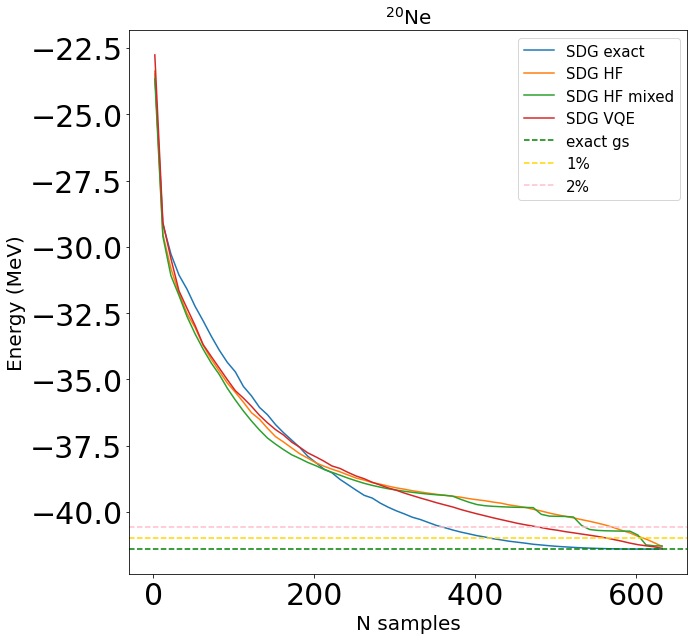

(64,)


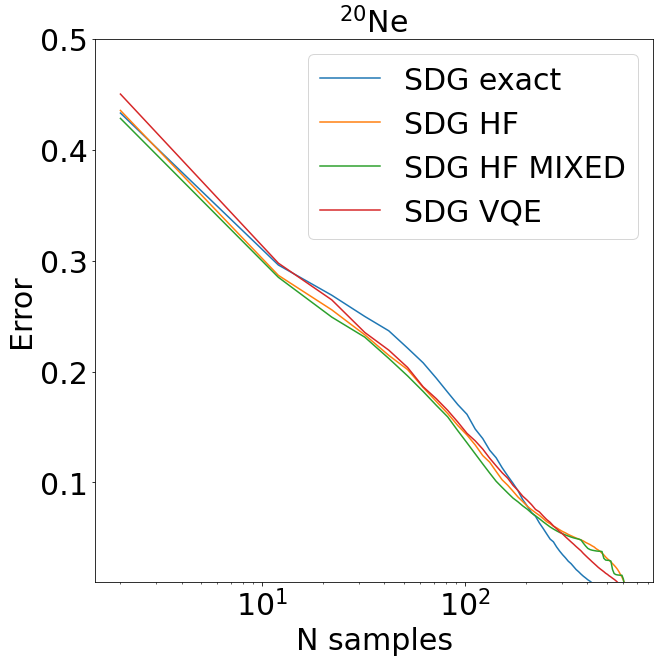

In [49]:
plt.figure(figsize=(10,10))
deviations_vqe=np.abs(np.asarray(deviations_vqe))
deviations=np.abs(np.asarray(deviations))
deviations_exact=np.abs(np.asarray(deviations_exact))
deviations_mixed=np.abs(np.asarray(deviations_mixed))
# plt.errorbar(ns_instances,energies_sdg_gs,yerr=deviations_exact[:,0],label='SDG exact')
# plt.errorbar(ns_instances,energies_sdg_hf,yerr=deviations[:,0],label='SDG HF')
# plt.errorbar(ns_instances,energies_sdg_hf_mixed,yerr=deviations_mixed[:,0],label='SDG HF mixed')
# plt.errorbar(ns_instances,energies_sdg_vqe,yerr=deviations_vqe[:,0],label='SDG VQE')

plt.plot(ns_instances,energies_sdg_gs,label='SDG exact')
plt.plot(ns_instances,energies_sdg_hf,label='SDG HF')
plt.plot(ns_instances,energies_sdg_hf_mixed,label='SDG HF mixed')
plt.plot(ns_instances,energies_sdg_vqe,label='SDG VQE')

#plt.axhline(y=model().detach().numpy(),color='red',linestyle='--',label='HF')
plt.axhline(y=egs[0],color='green',linestyle='--',label='exact gs')
plt.axhline(y=egs[0]*(0.99),color='gold',linestyle='--',label='1%')
plt.axhline(y=egs[0]*(0.98),color='pink',linestyle='--',label='2%')
plt.xlabel('N samples',fontsize=20)
plt.ylabel('Energy (MeV)',fontsize=20)
plt.legend(fontsize=15)
plt.title(title,fontsize=20)
plt.tick_params(labelsize=30)
plt.show()

energies_sdg_hf=np.asarray(energies_sdg_hf)
energies_sdg_gs=np.asarray(energies_sdg_gs)
energies_sdg_hf_mixed=np.asarray(energies_sdg_hf_mixed)
energies_sdg_vqe=np.asarray(energies_sdg_vqe)
print(energies_sdg_hf_mixed.shape)
plt.figure(figsize=(10,10))
plt.plot(ns_instances,np.abs((energies_sdg_gs-egs[0])/egs[0]),label='SDG exact')
plt.plot(ns_instances,np.abs((energies_sdg_hf-egs[0])/egs[0]),label='SDG HF')
plt.plot(ns_instances,np.abs((energies_sdg_hf_mixed-egs[0])/egs[0]),label='SDG HF MIXED')
plt.plot(ns_instances,np.abs((energies_sdg_vqe-egs[0])/egs[0]),label='SDG VQE')
plt.xlabel('N samples',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.tick_params(labelsize=30)
plt.ylim([10**-2,0.3])

plt.title(title,fontsize=30)
plt.semilogx()
plt.ylim([0.01,0.5])
plt.legend(fontsize=30)
plt.show()